**Model 1**: Weights distributed in a way that complete similarity between two vectors is given weight zero. Aside that, the higher the similarty (lower distance) the higher the weight between two neurons.

**Model 2**: Weights distributed in a way that complete similarity and no similarity between two vectors is given weight zero. Aside that, the higher the similarty (lower distance) the lower the weight between two neurons.

**Baseline 1**: Weights connected randomly (gaussian). 

**Baseline 2**: Weights all given a weight of zero.

In [117]:
#Download Necessary packages
import torch
import torchvision 
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import stats

In [118]:
#Download data and split into train and test images
train_dataset = datasets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = datasets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

#Initialize batch size
batch_size = 100

#Seprate data into batches
train_loader = DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True, num_workers = 4)

test_loader = DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False, num_workers = 4)

In [119]:
def weight_index(weight_matrix):                             #lets us know at which indexes, weights are zero
    num_rows, num_cols = weight_matrix.shape
    index_matrix = np.zeros((num_rows, num_cols))
    a = -1
    for i in range(num_rows):
        a = a + 1
        b = -1
        for j in range(num_cols):
            b = b + 1
            if weight_matrix[a][b] == 0:
                index_matrix[a][b] = 0
            else: index_matrix[a][b] = 1
    return index_matrix
                

**Neural Network Architecture**

In [120]:
#Building Neural Network
class FFNN(nn.Module):
    """Simple Feed Forward Neural Network with 1 hidden layer"""
    def __init__(self):
        super().__init__()
        self.accuracy_function = accuracy
        
        # Create first hidden layer
        self.input_layer = nn.Linear(784, 78)
        
        # Create output layer
        self.output_layer = nn.Linear(78, 10)
       
    def forward(self, input_image):
        # Flatten image
        input_image = input_image.view(input_image.size(0), -1)
        
        # Utilize hidden layers and apply activation function
        output = self.input_layer(input_image)
        output = F.relu(output)
        
        # Get predictions
        output = self.output_layer(output)
        output = F.softmax(output, dim = 1)
        return output

    def training_step(self, batch):
        # Load batch
        images, labels = batch
        
        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)
        return loss
    
    def testing_step(self, batch):
        # Load batch
        images, labels = batch 

        # Generate predictions
        output = self(images) 
        
        # Calculate loss
        loss = F.cross_entropy(output, labels)

        # Calculate accuracy
        acc = self.accuracy_function(output, labels)
        
        return {'test_loss': loss, 'test_acc': acc}
        
    def testing_epoch_end(self, outputs):
        batch_losses = [x['test_loss'] for x in outputs]
        
        # Combine losses and return mean value
        epoch_loss = torch.stack(batch_losses).mean()
        
        # Combine accuracies and return mean value
        batch_accs = [x['test_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch: {} - Testing Loss: {:.4f}, Testing Accuracy: {:.4f}".format(epoch, result['test_loss'], 
                                                                                  result['test_acc']))
def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item()*100/ len(preds))
    
def plot_history(history):
        losses = [x['test_loss'] for x in history]
        plt.plot(losses, '-x')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        accuracies = [x['test_acc'] for x in history]
        plt.plot(accuracies, '-x')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Loss', 'Accuracy'])
        plt.title('Loss and Accuracy');
        
def list_acc(history):
    acc = [x['test_acc'] for x in history]
    return acc 

def list_loss(history):
    losses = [x['test_loss'] for x in history]
    return losses

In [121]:
#initalize epoch number
epochs  = 5

#NN trainer
class ModelTrainer():   
    def fit(self, model, train_loader, test_loader):
        history = []
        optimizer = optim.Adam(model.parameters(), lr=0.0001) 

        for epoch in range(epochs):
            # Training 
            for batch in train_loader:
                loss = model.training_step(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            # Testing
            result = self._evaluate(model, test_loader)
            model.epoch_end(epoch, result)
            history.append(result)
            
        return history

    def _evaluate(self, model, test_loader):
        outputs = [model.testing_step(batch) for batch in test_loader]
        return model.testing_epoch_end(outputs)  

In [122]:
#NN trainer
class ModelTrainer2():   
    def fit(self, model, train_loader, test_loader, change_input, change_output):
        history = []
        optimizer = optim.Adam(model.parameters(), lr=0.0001) 

        for epoch in range(epochs):
            # Training 
            for batch in train_loader:
                loss = model.training_step(batch)
                loss.backward()
                optimizer.step()
                
            #initalize weights in input layer
                a = change_input.astype(np.float)
                model.input_layer.weight.data = model.input_layer.weight.data*a
                b = change_output.astype(np.float)
                model.output_layer.weight.data = model.output_layer.weight.data *b
                model.float()
                optimizer.zero_grad()

            # Testing
            result = self._evaluate(model, test_loader)
            model.epoch_end(epoch, result)
            history.append(result)
            
        return history

    def _evaluate(self, model, test_loader):
        outputs = [model.testing_step(batch) for batch in test_loader]
        return model.testing_epoch_end(outputs)  

**Basline 1: Gaussian weight distribution**

In [123]:
gaussian_model = FFNN()

def init_normal(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, 0, 0.0357)
            
gaussian_model.apply(init_normal)           
            
model_trainer = ModelTrainer()

model_trainer = ModelTrainer()

training_history = []
training_history += model_trainer.fit(gaussian_model, train_loader, test_loader)

gaussian_acc = list_acc(training_history)
gaussian_loss = list_loss(training_history)


Epoch: 0 - Testing Loss: 1.8008, Testing Accuracy: 73.0800
Epoch: 1 - Testing Loss: 1.6433, Testing Accuracy: 88.7900
Epoch: 2 - Testing Loss: 1.6002, Testing Accuracy: 90.2400
Epoch: 3 - Testing Loss: 1.5817, Testing Accuracy: 90.8500
Epoch: 4 - Testing Loss: 1.5710, Testing Accuracy: 91.2900


**Basline 2: Non random weight distribution**

In [124]:
nonrandom_model = FFNN()

def init_constant(m):
        if type(m) == nn.Linear:
            nn.init.constant_(m.weight, 1)
            
nonrandom_model.apply(init_constant)           
            
model_trainer2 = ModelTrainer()

training_history2 = []
training_history2 += model_trainer2.fit(nonrandom_model, train_loader, test_loader)

nonrandom_acc = list_acc(training_history2)
nonrandom_loss = list_loss(training_history2)

Epoch: 0 - Testing Loss: 2.2988, Testing Accuracy: 9.8000
Epoch: 1 - Testing Loss: 2.2410, Testing Accuracy: 21.0700
Epoch: 2 - Testing Loss: 2.2368, Testing Accuracy: 21.0400
Epoch: 3 - Testing Loss: 2.2345, Testing Accuracy: 21.1000
Epoch: 4 - Testing Loss: 2.2327, Testing Accuracy: 21.1100


**Function that trains ands test multiple pdch**

In [125]:
def history_auto(weight1, weight2):

     #initalize model
    model = FFNN()   

    #initalize weights in input layer
    weight_input = torch.tensor(weight1) 
    model.input_layer.weight.data = model.input_layer.weight.data*0.0 + weight_input

    #initalize weights in output layer
    weight_output = torch.tensor(weight2)  
    model.output_layer.weight.data = model.output_layer.weight.data *0.0 + weight_output
    
    #find indeces at which weights are zero
    change_input = weight_index(weight1)
    change_output = weight_index(weight2)
    
    #convert model to float
    model.float()

    #Train model
    model_trainer = ModelTrainer2()

    #record testing history
    training_history = []
    training_history += model_trainer.fit(model, train_loader, test_loader, change_input, change_output)

    return training_history

In [126]:
#Mann-Whitney
def mann_whitney(model1, model2, name1, name2):
    mann = scipy.stats.mannwhitneyu(model1, model2)
    print(mann)
    if mann[1] <= 0.05:
        print("Mann-Whitney Test between %s and %s: Statistically significant"%(name1, name2))
    else: 
        print("Mann-Whitney Test between %s and %s: Statistically NOT significant"%(name1, name2))

In [127]:
#Pearson r
def pearson_r(vectorx, vectory, name1, name2):
    correlation_acc = scipy.stats.pearsonr(vectorx, vectory)
    print("Pearson between %s and %s:"%(name1, name2), correlation_acc)

    if correlation_acc[1] <= 0.05:
        print("Statistically significant")
    else: 
        print("NOT stat significant")

In [128]:
def all_accuracy(model_type, vector_amounts):
    matrix_acc = np.empty((0, 5), float)
    
    for vector in vector_amounts:
        
        weight_input = np.loadtxt(open("model%sweightin_%s.txt"%(model_type, vector),"rb"),delimiter=",",skiprows=0)
        weight_output = np.loadtxt(open("model%sweightout_%s.txt"%(model_type, vector),"rb"),delimiter=",",skiprows=0)
    
        history = history_auto(weight_input, weight_output)
         
        #record accuracy and loss of testing
        model_acc = list_acc(history) 
        matrix_acc = np.append(matrix_acc, np.array([model_acc]), axis = 0)
        
    return matrix_acc                 #Returns matrix with accuracies for each pdch type amount

**Function to plot Pdch vs Accuracy across 2 Models**

In [129]:
def plot_pdch_accuracy(vector_amounts, matrix1, matrix2):
    model1 = []
    model2 = []
    
    for i in range(len(vector_amounts)):
        vectorm1 = matrix1[i]
        vectorm2 = matrix2[i]
        
        model1 = np.append(model1, vectorm1[4])
        model2 = np.append(model2, vectorm2[4])
    
    x = np.nanargmax(model1)
    y = np.nanargmax(model2)
    print("maximum accuracy at epoch 5 at for Model 1 is at %s"%vector_amounts[x])
    print("maximum accuracy at epoch 5 at for Model 2 is at %s"%vector_amounts[y])

    pearson_r(vector_amounts, model1, "Pdch types amount", "accuracy for model 1")        
    pearson_r(vector_amounts, model2, "Pdch types amount", "accuracy for model 2")
        
    mann_whitney(model1, model2, "model 1", "model 2")
    
    plt.plot(vector_amounts, model1, label = 'Model 1')
    plt.plot(vector_amounts, model2, label = 'Model 2')
    plt.title('Amount of Pdch isoforms vs Accuracy, epoch = 5')
    plt.xlabel('Pdch isoforms Amount')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

**Function to plot Learning across all Pdch, separate plot for Model 1 and 2**

In [130]:
X = np.arange(0, 5)

def plot_pdch_learning(model, vector_amounts, matrix_acc):
    for i in range(len(vector_amounts)):
        vector = matrix_acc[i]
        plt.plot(X, vector, label = "%s Pdch types"%vector_amounts[i])
    plt.plot(X, nonrandom_acc,label="Non-random baseline")
    plt.plot(X, gaussian_acc, label = "Random baseline")
    plt.title('Model %s: Learning across different Pdch isoforms amounts '%(model))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor = (1.05, 0.6))
    plt.show()

    mann_whitney(matrix_acc[0], matrix_acc[1], "18 Pdch types", "33 Pdch types")
    mann_whitney(matrix_acc[0], gaussian_acc, "18 Pdch types", "gaussian")
    mann_whitney(matrix_acc[1], gaussian_acc, "33 Pdch types", "gaussian")
    mann_whitney(matrix_acc[0], nonrandom_acc, "18 Pdch types", "nonrandom")
    mann_whitney(matrix_acc[1], nonrandom_acc, "33 Pdch types", "nonrandom")

**Function to plot Epoch vs Accuracy across models, Amount of Pdch types = 15, and 30**

In [149]:
X = np.arange(0, 5)

def plot_model_learning(model1_Acc, model2_Acc):
    
    #Stat significant differences    
    mann_whitney(model1_Acc[0], nonrandom_acc, "Model 1 with 12 Pdch types", "non-random model")
    mann_whitney(model1_Acc[1], nonrandom_acc, "Model 1 with 39 Pdch types", "non-random model")
    mann_whitney(model2_Acc[0], nonrandom_acc, "Model 1 with 12 Pdch types", "non-random model")
    mann_whitney(model2_Acc[1], nonrandom_acc, "Model 1 with 39 Pdch types", "non-random model")  
    mann_whitney(gaussian_acc, nonrandom_acc, "Model 1 with 12 Pdch types", "non-random model")
    
    mann_whitney(model1_Acc[0], model1_Acc[1], "Model 1 with 15 Pdch types", "with 54")
    mann_whitney(model2_Acc[0], model1_Acc[0], "Model 2 with 15 Pdch types", "Model 1 with 15")
    mann_whitney(model2_Acc[0], model1_Acc[1], "Model 2 with 15 Pdch types", "Model 1 with 54")
    mann_whitney(model2_Acc[1], model1_Acc[0], "Model 2 with 58 Pdch types", "Model 1 with 15")
    mann_whitney(model2_Acc[1], model1_Acc[1], "Model 2 with 58 Pdch types", "Model 1 with 54")
    mann_whitney(model2_Acc[0], model2_Acc[1], "Model 2 with 15 Pdch types", "with 54")
    
    mann_whitney(model1_Acc[0], gaussian_acc, "Model 1 with 15 Pdch types", "gaussian model")
    mann_whitney(model1_Acc[1], gaussian_acc, "Model 1 with 58 Pdch types", "gaussian model")
    mann_whitney(model2_Acc[0], gaussian_acc, "Model 1 with 15 Pdch types", "gaussian model")
    mann_whitney(model2_Acc[1], gaussian_acc, "Model 1 with 58 Pdch types", "gaussian model")  
    mann_whitney(nonrandom_acc, gaussian_acc, "Model 1 with 58 Pdch types", "gaussian model")
    
    #stat significant correlations
    pearson_r(X, model1_Acc[0], "Model 1 with 15 Pdch types", "learning")
    pearson_r(X, model1_Acc[1], "Model 1 with 58 Pdch types", "learning")
    pearson_r(X, model2_Acc[0], "Model 1 with 15 Pdch types", "learning")
    pearson_r(X, model2_Acc[1], "Model 1 with 58 Pdch types", "learning")
    pearson_r(X, gaussian_acc,  "Gaussian model", "learning")
    pearson_r(X, nonrandom_acc, "Non random model", "learning")
    
    plt.plot(X, model1_Acc[0], label = "Model 1: 12 Pdch isoforms")
    plt.plot(X, model1_Acc[1], label = "Model 1: 39 Pdch isoforms")
    plt.plot(X, model2_Acc[0], label = "Model 2: 12 Pdch isoforms")
    plt.plot(X, model2_Acc[1], label = "Model 2: 39 Pdch isoforms")
    plt.plot(X, nonrandom_acc,label="Non-random baseline")
    plt.plot(X, gaussian_acc, label = "Random baseline")
    plt.title('Learning across Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor = (1.05, 0.6))
    plt.show()

**Design a function to plot shape(parameter in weight) vs accuracy for a specific model at epoch 5**

In [151]:
def unpack_scale_m1(scale, pdch):
    matrix_acc = np.empty((0, 5), float)
    loadm1_in = np.loadtxt(open("%smodel1weightin_skew%s.txt"%(pdch, scale),"rb"),delimiter=",",skiprows=0)
    loadm1_out = np.loadtxt(open("%smodel1weightout_skew%s.txt"%(pdch,scale),"rb"),delimiter=",",skiprows=0)
    history = history_auto(loadm1_in, loadm1_out)
    model_acc = list_acc(history) 
    matrix_acc = np.append(matrix_acc, np.array([model_acc]), axis = 0)
    return model_acc
    
def unpack_scale_m2(scale, pdch):
    matrix_acc = np.empty((0, 5), float)
    loadm2_in = np.loadtxt(open("%smodel2weightin_skew%s.txt"%(pdch, scale),"rb"),delimiter=",",skiprows=0)
    loadm2_out = np.loadtxt(open("%smodel2weightout_skew%s.txt"%(pdch, scale),"rb"),delimiter=",",skiprows=0)
    history = history_auto(loadm2_in, loadm2_out)
    model_acc = list_acc(history) 
    return model_acc
    

def plot_scale():
    x = [0.21, 0.18, 0.15, 0.12, 0.09, 0.06]
    s1 = [] 
    s2 = []
    s3 = []
    s4 = []
    for scale in x:
        scale = int(scale*100)
        m1_33 = unpack_scale_m1(scale, 39)
        s1 = np.append(s1, m1_33[4])
        m1_18 = unpack_scale_m1(scale, 12)
        s2 = np.append(s2, m1_18[4])
        m2_33 = unpack_scale_m2(scale, 39)
        s3 = np.append(s3, m2_33[4])
        m2_18 = unpack_scale_m2(scale, 12)  
        s4 = np.append(s4, m2_18[4]) 
        
    pearson_r(x, s1, "scale", "accuracy for model 1 with 33 Pdch isoforms")        
    pearson_r(x, s2, "scale", "accuracy for model 1 with 18 Pdch isoforms")
    pearson_r(x, s3, "scale", "accuracy for model 2 with 33 Pdch isoforms")        
    pearson_r(x, s4, "scale", "accuracy for model 2 with 18 Pdch isoforms")

                
    mann_whitney(s1, s2, "model 1 with 33 Pdch isoforms", "model 1 with 18 pdch")
    mann_whitney(s1, s3, "model 1 with 33 Pdch isoforms", "model 2 with 33")
    mann_whitney(s1, s4, "model 1 with 33 Pdch isoforms", "model 2 with 18 pdch")
    mann_whitney(s2, s3, "model 1 with 18 Pdch isoforms", "model 2 with 33")   
    mann_whitney(s2, s4, "model 1 with 18 Pdch isoforms", "model 2 with 18 pdch")
    mann_whitney(s3, s4, "model 2 with 33 Pdch isoforms", "model 2 with 18")   
    
    plt.plot(x, s1, label = "Model 1 with 39 Pdch isoforms" )
    plt.plot(x, s2, label = "Model 1 with 12 Pdch isoforms" )
    plt.plot(x, s3, label = "Model 2 with 39 Pdch isoforms" )
    plt.plot(x, s4, label = "Model 2 with 12 Pdch isoforms" )
    plt.title('Scale vs Accuracy, epoch = 5')
    plt.xlabel('Scale')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Epoch: 0 - Testing Loss: 2.1314, Testing Accuracy: 32.3700
Epoch: 1 - Testing Loss: 2.0954, Testing Accuracy: 36.0600
Epoch: 2 - Testing Loss: 2.0082, Testing Accuracy: 45.0300
Epoch: 3 - Testing Loss: 1.9968, Testing Accuracy: 46.0600
Epoch: 4 - Testing Loss: 1.9912, Testing Accuracy: 46.6900
Epoch: 0 - Testing Loss: 1.8596, Testing Accuracy: 61.9800
Epoch: 1 - Testing Loss: 1.7953, Testing Accuracy: 67.5500
Epoch: 2 - Testing Loss: 1.7639, Testing Accuracy: 70.4700
Epoch: 3 - Testing Loss: 1.7401, Testing Accuracy: 72.9500
Epoch: 4 - Testing Loss: 1.7299, Testing Accuracy: 73.7600
Epoch: 0 - Testing Loss: 1.9901, Testing Accuracy: 50.0600
Epoch: 1 - Testing Loss: 1.7644, Testing Accuracy: 72.9700
Epoch: 2 - Testing Loss: 1.6913, Testing Accuracy: 80.5700
Epoch: 3 - Testing Loss: 1.6696, Testing Accuracy: 81.5600
Epoch: 4 - Testing Loss: 1.6573, Testing Accuracy: 82.3700
Epoch: 0 - Testing Loss: 1.8609, Testing Accuracy: 66.0200
Epoch: 1 - Testing Loss: 1.7770, Testing Accuracy: 71.78

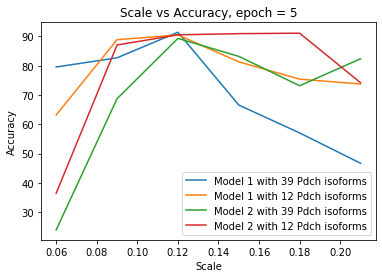

In [152]:
plot_scale()

**Graphing**

In [135]:
#Initialize variables
pdch_type= [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 58]

model1_acc  = all_accuracy(1, pdch_type)

Epoch: 0 - Testing Loss: 2.2119, Testing Accuracy: 24.5900
Epoch: 1 - Testing Loss: 2.1440, Testing Accuracy: 31.4000
Epoch: 2 - Testing Loss: 2.0996, Testing Accuracy: 35.8600
Epoch: 3 - Testing Loss: 2.0715, Testing Accuracy: 38.7500
Epoch: 4 - Testing Loss: 2.0510, Testing Accuracy: 40.7400
Epoch: 0 - Testing Loss: 2.2032, Testing Accuracy: 25.2800
Epoch: 1 - Testing Loss: 2.0999, Testing Accuracy: 35.7800
Epoch: 2 - Testing Loss: 2.0892, Testing Accuracy: 36.7200
Epoch: 3 - Testing Loss: 2.0012, Testing Accuracy: 45.7300
Epoch: 4 - Testing Loss: 1.9708, Testing Accuracy: 48.5300
Epoch: 0 - Testing Loss: 2.1845, Testing Accuracy: 27.0800
Epoch: 1 - Testing Loss: 2.1323, Testing Accuracy: 32.1400
Epoch: 2 - Testing Loss: 2.0683, Testing Accuracy: 38.7600
Epoch: 3 - Testing Loss: 2.0231, Testing Accuracy: 43.2600
Epoch: 4 - Testing Loss: 1.9432, Testing Accuracy: 51.4300
Epoch: 0 - Testing Loss: 1.9948, Testing Accuracy: 47.1800
Epoch: 1 - Testing Loss: 1.9227, Testing Accuracy: 54.54

In [143]:
model2_acc = all_accuracy(2, pdch_type)

Epoch: 0 - Testing Loss: 2.0650, Testing Accuracy: 40.4200
Epoch: 1 - Testing Loss: 1.8219, Testing Accuracy: 66.6900
Epoch: 2 - Testing Loss: 1.7514, Testing Accuracy: 72.7500
Epoch: 3 - Testing Loss: 1.7311, Testing Accuracy: 74.3900
Epoch: 4 - Testing Loss: 1.7215, Testing Accuracy: 74.9200
Epoch: 0 - Testing Loss: 1.8900, Testing Accuracy: 61.8200
Epoch: 1 - Testing Loss: 1.7357, Testing Accuracy: 78.7900
Epoch: 2 - Testing Loss: 1.6740, Testing Accuracy: 82.2000
Epoch: 3 - Testing Loss: 1.6540, Testing Accuracy: 83.1200
Epoch: 4 - Testing Loss: 1.6436, Testing Accuracy: 83.5300
Epoch: 0 - Testing Loss: 2.1496, Testing Accuracy: 30.1400
Epoch: 1 - Testing Loss: 2.1427, Testing Accuracy: 30.5600
Epoch: 2 - Testing Loss: 2.1230, Testing Accuracy: 32.7100
Epoch: 3 - Testing Loss: 2.0719, Testing Accuracy: 38.3500
Epoch: 4 - Testing Loss: 2.0667, Testing Accuracy: 38.7800
Epoch: 0 - Testing Loss: 2.0015, Testing Accuracy: 46.1500
Epoch: 1 - Testing Loss: 1.8328, Testing Accuracy: 65.39

maximum accuracy at epoch 5 at for Model 1 is at 21
maximum accuracy at epoch 5 at for Model 2 is at 54
Pearson between Pdch types amount and accuracy for model 1: (-0.07671016565216503, 0.754940334647895)
NOT stat significant
Pearson between Pdch types amount and accuracy for model 2: (0.16143870825497583, 0.5090777332094035)
NOT stat significant
MannwhitneyuResult(statistic=26.0, pvalue=3.4583309156087685e-06)
Mann-Whitney Test between model 1 and model 2: Statistically significant


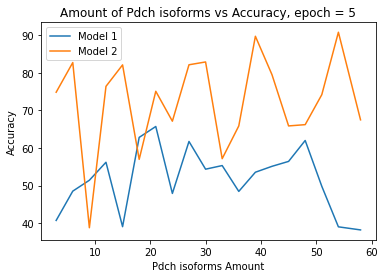

In [139]:
plot_pdch_accuracy(pdch_type, model1_acc, model2_acc)

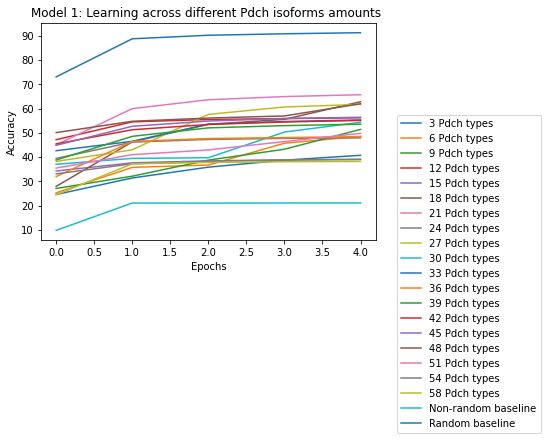

MannwhitneyuResult(statistic=9.0, pvalue=0.2654346519842541)
Mann-Whitney Test between 18 Pdch types and 33 Pdch types: Statistically NOT significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between 18 Pdch types and gaussian: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between 33 Pdch types and gaussian: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between 18 Pdch types and nonrandom: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between 33 Pdch types and nonrandom: Statistically significant


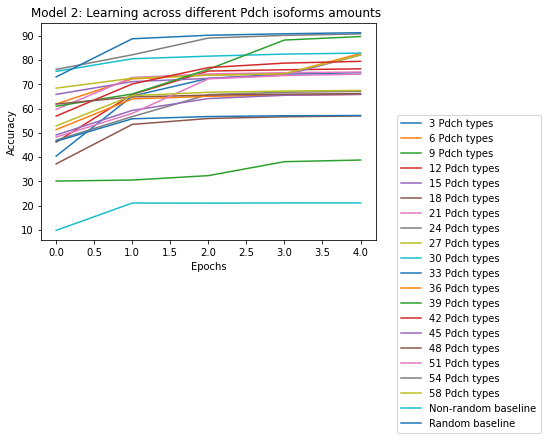

MannwhitneyuResult(statistic=10.0, pvalue=0.33805165701157347)
Mann-Whitney Test between 18 Pdch types and 33 Pdch types: Statistically NOT significant
MannwhitneyuResult(statistic=2.0, pvalue=0.01835692818135205)
Mann-Whitney Test between 18 Pdch types and gaussian: Statistically significant
MannwhitneyuResult(statistic=3.0, pvalue=0.030051402969433157)
Mann-Whitney Test between 33 Pdch types and gaussian: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between 18 Pdch types and nonrandom: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between 33 Pdch types and nonrandom: Statistically significant


In [141]:
plot_pdch_learning(1, pdch_type, model1_acc)
plot_pdch_learning(2, pdch_type, model2_acc)

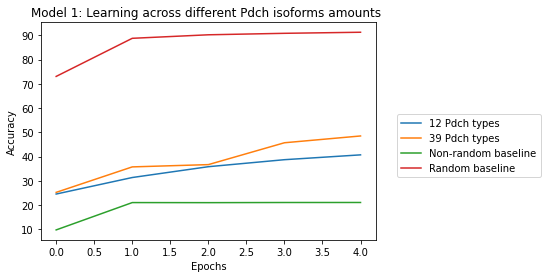

MannwhitneyuResult(statistic=9.0, pvalue=0.2654346519842541)
Mann-Whitney Test between 18 Pdch types and 33 Pdch types: Statistically NOT significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between 18 Pdch types and gaussian: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between 33 Pdch types and gaussian: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between 18 Pdch types and nonrandom: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between 33 Pdch types and nonrandom: Statistically significant


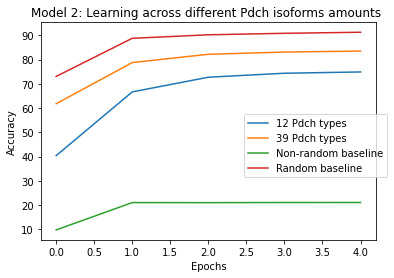

MannwhitneyuResult(statistic=4.0, pvalue=0.047346471299737944)
Mann-Whitney Test between 18 Pdch types and 33 Pdch types: Statistically significant
MannwhitneyuResult(statistic=2.0, pvalue=0.01835692818135205)
Mann-Whitney Test between 18 Pdch types and gaussian: Statistically significant
MannwhitneyuResult(statistic=4.0, pvalue=0.047346471299737944)
Mann-Whitney Test between 33 Pdch types and gaussian: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between 18 Pdch types and nonrandom: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between 33 Pdch types and nonrandom: Statistically significant


In [145]:
plot_pdch_learning(1, pdch_type1, model1_acc)
plot_pdch_learning(2, pdch_type1, model2_acc)

In [147]:
pdch_type1 = [12, 39]
model1_pdch  = all_accuracy(1, pdch_type1)
model2_pdch  = all_accuracy(2, pdch_type1)
    

Epoch: 0 - Testing Loss: 1.9981, Testing Accuracy: 46.8000
Epoch: 1 - Testing Loss: 1.9239, Testing Accuracy: 54.3400
Epoch: 2 - Testing Loss: 1.9090, Testing Accuracy: 55.4900
Epoch: 3 - Testing Loss: 1.9028, Testing Accuracy: 55.9800
Epoch: 4 - Testing Loss: 1.8991, Testing Accuracy: 56.1900
Epoch: 0 - Testing Loss: 2.0695, Testing Accuracy: 38.7700
Epoch: 1 - Testing Loss: 1.9632, Testing Accuracy: 49.5500
Epoch: 2 - Testing Loss: 1.9376, Testing Accuracy: 52.2500
Epoch: 3 - Testing Loss: 1.9278, Testing Accuracy: 53.0500
Epoch: 4 - Testing Loss: 1.9223, Testing Accuracy: 53.5100
Epoch: 0 - Testing Loss: 2.0047, Testing Accuracy: 45.9200
Epoch: 1 - Testing Loss: 1.7590, Testing Accuracy: 73.8700
Epoch: 2 - Testing Loss: 1.7234, Testing Accuracy: 75.6800
Epoch: 3 - Testing Loss: 1.7115, Testing Accuracy: 76.1300
Epoch: 4 - Testing Loss: 1.7050, Testing Accuracy: 76.3600
Epoch: 0 - Testing Loss: 1.8915, Testing Accuracy: 63.0500
Epoch: 1 - Testing Loss: 1.8214, Testing Accuracy: 66.02

MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between Model 1 with 12 Pdch types and non-random model: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between Model 1 with 39 Pdch types and non-random model: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between Model 1 with 12 Pdch types and non-random model: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between Model 1 with 39 Pdch types and non-random model: Statistically significant
MannwhitneyuResult(statistic=0.0, pvalue=0.006092890177672406)
Mann-Whitney Test between Model 1 with 12 Pdch types and non-random model: Statistically significant
MannwhitneyuResult(statistic=9.0, pvalue=0.2654346519842541)
Mann-Whitney Test between Model 1 with 15 Pdch types and with 54: Statistically NOT significant
MannwhitneyuResult(stat

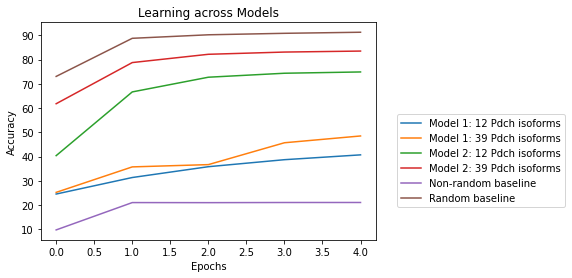

In [150]:
plot_model_learning(model1_acc, model2_acc)